# Create spreadsheet(s) for:
- Number of impaired days (Current or Scenario - Reference < 0.2)
- Percent volume of Baseline - Scenario < 0.2 mg/l
- Percent volume per run of DO < 2 mg/l
- Percent volume per run of DO < 5 mg/l
Note: the `SSMGrid2_07222022` shapefile version does not have masked regions attributed 

In [1]:
import sys
import os
sys.path.insert(1, '../scripts/')
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom, calc_fvcom_stat, extract_fvcom_level

### Define study focus and analysis scope 
- scope: wc for water column or benthic for bottom-level

In [2]:
case = "SOG_NB"
scope= "wc" # "benthic" or "wc"

### Load configuration file (yaml) and shapefile

In [3]:
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# get shapefile path    
shp = ssm['paths']['shapefile']
# load shapefile into geopandas dataframe
gdf = gpd.read_file(shp)
gdf=gdf.rename(columns={'region_inf':'Regions'})

In [4]:
# Initialize dictionaries
MinDO_full={} # Min, daily DO over all nodes
MinDO={} # Min, daily DO over all nodes in shapefile
DO_diff_lt_0p2={} # Boolean where DO<threshold
DO_diff_lt_0p2_days={} # Number of days where DOBelowThresh = True
DaysImpaired={} # Sum of days across regions
VolumeDaysImpaired={} # Percent of volume within region where DO<threshold
PercentVolumeDaysImpaired={}

# Define dimension sizes and load shapefile
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

# Get path for model output
model_var='DOXG' 
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/case/model_var

# Get list of run sub-directories in processed netcdf directory
dir_list = os.listdir(processed_netcdf_dir)

# Load all runs (including reference case)
if scope=='benthic':
    print("Benthic case")
    for run_dir in dir_list: 
        try: 
            run_file=processed_netcdf_dir/run_dir/'bottom'/f'daily_min_{model_var}_bottom.nc'
            with xarray.open_dataset(run_file) as ds:
                print([*ds])
                MinDO_full[run_dir]=ds[f'{model_var}_daily_min_bottom']
                # Sub-sample nodes (from 16012 nodes to 7494)
                MinDO[run_dir]=MinDO_full[run_dir][:,gdf['node_id']-1]
                print(MinDO[run_dir].shape)
        except FileNotFoundError:
            print(f'File Not Found: {run_file}')
        if run_dir == dir_list[0]:
            # Get number of days and nodes
            [ndays,nnodes]=MinDO[run_dir].shape
else: # water column (with 10 levels)
    print("Water Column")
    for run_dir in dir_list:
        try: 
            run_file=processed_netcdf_dir/run_dir/f'daily_min_{model_var}.nc'
            with xarray.open_dataset(run_file) as ds:
                print([*ds])
                MinDO_full[run_dir]=ds[f'{model_var}_daily_min']
                # Sub-sample nodes (from 16012 nodes to 7494)
                MinDO[run_dir]=MinDO_full[run_dir][:,:,gdf['node_id']-1]
                print(MinDO[run_dir].shape)
        except FileNotFoundError:
            print(f'File Not Found: {run_file}')
        if run_dir == dir_list[0]:
            # Get number of days and nodes
            [ndays,nlevels,nnodes]=MinDO[run_dir].shape

# Calculate volume for volume days
if scope=='benthic':
    volume = np.asarray(
        gdf.volume*ssm['siglev_diff'][-1]/100) # just the bottom level
else: # water column
    volume = np.asarray(gdf.volume)
    depth_fraction = np.array(ssm['siglev_diff'])/100
    volume2D = np.dot(volume.reshape(nnodes,1),depth_fraction.reshape(1,nlevels))

# Define reference run
reference = ssm['run_information']['reference']
print(reference)
dir_list.remove(reference)

Water Column
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
wqm_reference


In [5]:
impairment=-0.25

# Loop through all non-reference runs and calculate impairment
for run_type in dir_list[0:1]:
    print(f'Calculating difference for {run_type}')
    # Create array of Dissolved Oxygen threshold values 
    DO_diff = MinDO[run_type] - MinDO[reference]
    # Boolean where DO_diff < -0.2 (or impairment value)
    DO_diff_lt_0p2[run_type] = DO_diff<=impairment #361x4144 (nodes x time) or 361x10x4144
    # Number of days where DO < threshold = True
    if scope=='benthic':
        DO_diff_lt_0p2_days[run_type]=DO_diff_lt_0p2[run_type].sum(
            axis=0, initial=0) #4144 (nodes) or 10x4144
        VolumeDays_all=volume*DO_diff_lt_0p2_days[run_type]
    else: # water column: sum over days and take max value over depth
        # First get a count of days impaired for each depth level
        DO_diff_lt_0p2_days_wc=DO_diff_lt_0p2[run_type].sum(
            axis=0, initial=0)
        # Volume days: Use days impaired for each level  and element-wise 
        # multiplication of 10x4144 * 10x4144 matrices to get volume days by level
        VolumeDays_wc=volume2D.transpose()*DO_diff_lt_0p2_days_wc
        # Add across levels to get total VolumeDays per node
        VolumeDays_all = VolumeDays_wc.sum(axis=0)

    # Total number of days and percent volume days for each region
    DaysImpaired[run_type]={}
    VolumeDaysImpaired[run_type]={}
    PercentVolumeDaysImpaired[run_type]={}
    for region in regions:
        # create boolean of indices where True selects nodes of 
        # specified Region 
        idx = ((gdf['Regions']==region) &
            (gdf['included_i']==1))            
        # Note: The max of True/False will be True and initial sets False to zero.
        # The "where" keywork specifies to only use values where idx=True,
        # which in this case I set to specify the region.
        if scope=='benthic':
            # Assign the maximum (True) of DO < threshold occurrence anywhere in region
            # then sum values over time
            DaysImpaired[run_type][region] = DO_diff_lt_0p2[run_type].max(
                axis=1,where=idx,initial=0).sum().item()
        else:
            # Assign the maximum (True) of DO < threshold occurrence across depths 
            # such that 1-day of impairement is counted if there is one or more 
            # levels impaired
            DOBelowThresh_daysnodes = DO_diff_lt_0p2[run_type].max(axis=1,initial=0)
            # Assign the maximum (True) of DO < threshold occurrence 
            # anywhere in region then sum values over time
            DaysImpaired[run_type][region] = DOBelowThresh_daysnodes.max(
                axis=1,where=idx,initial=0).sum().item()

        VolumeDaysImpaired[run_type][region]=np.array(VolumeDays_all)[
            (gdf['Regions']==region) &
            (gdf['included_i']==1)
        ].sum()
        # get regional volume
        if scope=='benthic': # take fraction for bottom-level volume
            RegionVolume = ssm['siglev_diff'][-1]/100*volume[
                (gdf['Regions']==region) &
                (gdf['included_i']==1)
            ].sum()
        else: # water column
            RegionVolume = volume[
                (gdf['Regions']==region) &
                (gdf['included_i']==1)
            ].sum()
        PercentVolumeDaysImpaired[run_type][region]=100*(
            VolumeDaysImpaired[run_type][region]/(RegionVolume*ndays)
        )

Calculating difference for 1c_all_sog_riv_off


In [15]:
idx = (gdf['Regions']!='Other')

In [25]:
np.asarray(VolumeDays_all)[idx].shape

(4115,)

In [26]:
VolumeDays_all.shape

(4144,)

In [27]:
4144-4115

29

In [8]:
DO_diff_lt_0p2[run_type].max(
        axis=2,initial=0).max(axis=1,initial=0).shape

(361,)

In [ ]:
# Create totals across entire domain 
if scope=='benthic': #(361x4771): max over nodes and sum over time
    DaysImpaired[run_type]['ALL_REGIONS'] = DO_diff_lt_0p2[run_type].max(
        axis=1, initial=0).sum(axis=0,initial=0).item()
else: #(361x10x4771): max over nodes and depth and sum over time
    DaysImpaired[run_type]['ALL_REGIONS'] = DO_diff_lt_0p2[run_type].max(
        axis=2,initial=0).max(axis=1,initial=0).sum(axis=0,initial=0).item()
VolumeDaysImpaired[run_type]['ALL_REGIONS'] = VolumeDays_all.sum().item()
PercentVolumeDaysImpaired[run_type]['ALL_REGIONS'] = 100*(
    VolumeDays_all.sum().item()/(volume.sum().item()*ndays)
)

### Work out removing 'Other' nodes from volume

### Debug method for days impaired

In [17]:
MinDO_full={}
MinDO={}
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/'DOXG'
scenario= processed_netcdf_dir/'wqm_baseline'/f'daily_min_DOXG.nc'
reference= processed_netcdf_dir/'wqm_reference'/f'daily_min_DOXG.nc'
DO_thresh=-0.2
with xarray.open_dataset(scenario) as ds:
    print([*ds])
    MinDO_full['wqm_baseline']=ds[f'DOXG_daily_min']
    MinDO['wqm_baseline']=MinDO_full['wqm_baseline'][:,:,gdf['node_id']-1]
with xarray.open_dataset(reference) as ds:
    print([*ds])
    MinDO_full['wqm_reference']=ds[f'DOXG_daily_min']
    MinDO['wqm_reference']=MinDO_full['wqm_reference'][:,:,gdf['node_id']-1]

['DOXG_daily_min']
['DOXG_daily_min']


In [35]:
[ndays,nlevels,nnodes]=MinDO['wqm_baseline'].shape

In [36]:
volume = np.asarray(gdf.volume)
depth_fraction = np.array(ssm['siglev_diff'])/100
volume2D = np.dot(volume.reshape(nnodes,1),depth_fraction.reshape(1,nlevels))

In [37]:
volume2D.shape

(4144, 10)

In [18]:
DO_diff = MinDO['wqm_baseline'] - MinDO['wqm_reference']
# Boolean where DO_diff<0.2
DO_diff_lt_0p2 = DO_diff<=-0.2 #361x4144 (nodes x time) or 361x10x4144

In [19]:
DO_diff_lt_0p2.shape

(361, 10, 4144)

In [21]:
# First get a count of days impaired for each depth level
DO_diff_lt_0p2_days_wc=DO_diff_lt_0p2.sum(axis=0)
# Take max over depth to get result similar to benthic case where
# 1-day of impairement is counted if there is one or more levels impaired
DO_diff_lt_0p2_days=DO_diff_lt_0p2.sum(axis=0).max(axis=0)


In [38]:
DO_diff_lt_0p2_days_wc.shape

(10, 4144)

In [40]:
# Volume days: Use days impaired for each level  and element-wise 
# multiplication of 10x4144 * 10x4144 matrices to get volume days by level
VolumeDays_wc=volume2D.transpose()*DO_diff_lt_0p2_days_wc


In [41]:
VolumeDays_wc.shape

(10, 4144)

In [42]:
# Add across levels to get total VolumeDays per node
VolumeDays_all = VolumeDays_wc.sum(axis=0)

In [23]:
DOBelowThresh_daysnodes = DO_diff_lt_0p2.max(axis=1,initial=0)

In [24]:
DOBelowThresh_daysnodes.shape

(361, 4144)

In [25]:
idx = ((gdf['Regions']=='Hood') &
       (gdf['included_i']==1))                     

DaysImpaired = DOBelowThresh_daysnodes.max(
    axis=1,where=idx,initial=0)
  

In [26]:
DaysImpaired.shape

(361,)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


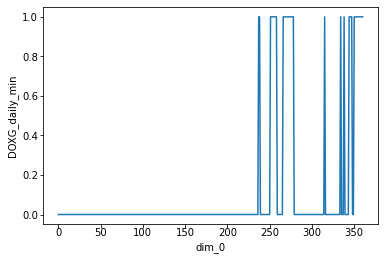

In [27]:
DaysImpaired.plot()

In [5]:
impairment=-0.2
# Initialize dictionaries
MinDO_full={} # Min, daily DO over all nodes
MinDO={} # Min, daily DO over all nodes in shapefile
DO_diff_lt_0p2={} # Boolean where DO<threshold
DO_diff_lt_0p2_days={} # Number of days where DOBelowThresh = True
DaysImpaired={} # Sum of days across regions
VolumeDaysImpaired={} # Percent of volume within region where DO<threshold
PercentVolumeDaysImpaired={}

# Define dimension sizes and load shapefile
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

# Get path for model output
model_var='DOXG' 
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/model_var

# Get list of run sub-directories in processed netcdf directory
dir_list = os.listdir(processed_netcdf_dir)

# Load all runs (including reference case)
if scope=='benthic':
    print("Benthic case")
    for run_dir in dir_list: 
        try: 
            run_file=processed_netcdf_dir/run_dir/'bottom'/f'daily_min_{model_var}_bottom.nc'
            with xarray.open_dataset(run_file) as ds:
                print([*ds])
                MinDO_full[run_dir]=ds[f'{model_var}_daily_min_bottom']
                # Sub-sample nodes (from 16012 nodes to 7494)
                MinDO[run_dir]=MinDO_full[run_dir][:,gdf['node_id']-1]
                print(MinDO[run_dir].shape)
        except FileNotFoundError:
            print(f'File Not Found: {run_file}')
        if run_dir == dir_list[0]:
            # Get number of days and nodes
            [ndays,nnodes]=MinDO[run_dir].shape
else: # water column (with 10 levels)
    print("Water Column")
    for run_dir in dir_list:
        try: 
            run_file=processed_netcdf_dir/run_dir/f'daily_min_{model_var}.nc'
            with xarray.open_dataset(run_file) as ds:
                print([*ds])
                MinDO_full[run_dir]=ds[f'{model_var}_daily_min']
                # Sub-sample nodes (from 16012 nodes to 7494)
                MinDO[run_dir]=MinDO_full[run_dir][:,:,gdf['node_id']-1]
                print(MinDO[run_dir].shape)
        except FileNotFoundError:
            print(f'File Not Found: {run_file}')
        if run_dir == dir_list[0]:
            # Get number of days and nodes
            [ndays,nlevels,nnodes]=MinDO[run_dir].shape
# Calculate volume for volume days
if scope=='benthic':
    volume = np.asarray(
        gdf.volume*ssm['siglev_diff'][-1]/100) # just the bottom level
else: # water column
    volume = np.asarray(gdf.volume)
    depth_fraction = np.array(ssm['siglev_diff'])/100
    volume2D = np.dot(volume.reshape(nnodes,1),depth_fraction.reshape(1,nlevels))

# Define reference run
reference = ssm['run_information']['reference']
print(reference)
dir_list.remove(reference)

# Loop through all non-reference runs and calculate impairment
for run_type in dir_list[0:1]:
    print(f'Calculating difference for {run_type}')
    # Create array of Dissolved Oxygen threshold values 
    DO_diff = MinDO[run_type] - MinDO[reference]
    # Boolean where DO_diff<-0.2
    DO_diff_lt_0p2[run_type] = DO_diff<=impairment #361x4144 (nodes x time) or 361x10x4144
    # Number of days where DO < threshold = True
    if scope=='benthic':
        DO_diff_lt_0p2_days[run_type]=DO_diff_lt_0p2[run_type].sum(axis=0) #4144 (nodes) or 10x4144
        VolumeDays_all=volume*DO_diff_lt_0p2_days[run_type]
    else: # water column: sum over days and take max value over depth
        # First get a count of days impaired for each depth level
        DO_diff_lt_0p2_days_wc=DO_diff_lt_0p2[run_type].sum(axis=0)
        # Volume days: Use days impaired for each level  and element-wise 
        # multiplication of 10x4144 * 10x4144 matrices to get volume days by level
        VolumeDays_wc=volume2D.transpose()*DO_diff_lt_0p2_days_wc
        # Add across levels to get total VolumeDays per node
        VolumeDays_all = VolumeDays_wc.sum(axis=0)

    # Total number of days and percent volume days for each region
    DaysImpaired[run_type]={}
    VolumeDaysImpaired[run_type]={}
    PercentVolumeDaysImpaired[run_type]={}
    for region in regions:
        # create boolean of indices where True selects nodes of 
        # specified Region 
        idx = ((gdf['Regions']==region) &
            (gdf['included_i']==1))            
        # Note: The max of True/False will be True and initial sets False to zero.
        # The "where" keywork specifies to only use values where idx=True,
        # which in this case I set to specify the region.
        if scope=='benthic':
            # Assign the maximum (True) of DO < threshold occurrence across region
            DaysImpaired[run_type][region] = DO_diff_lt_0p2[run_type].max(
                axis=1,where=idx,initial=0)
        else:
            # Assign the maximum (True) of DO < threshold occurrence across depths 
            # such that 1-day of impairement is counted if there is one or more 
            # levels impaired
            DOBelowThresh_daysnodes = DO_diff_lt_0p2[run_type].max(axis=1,initial=0)
            # Assign the maximum (True) of DO < threshold occurrence across region
            DaysImpaired[run_type][region] = DOBelowThresh_daysnodes.max(
                axis=1,where=idx,initial=0)

Water Column
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
wqm_reference
Calculating difference for 1c_all_sog_riv_off


In [8]:
DO_diff_lt_0p2[run_type].max(axis=2).max(axis=1).sum(axis=0).item()

281

In [9]:
VolumeDays_all.sum().item()

111.67020858720899

In [13]:
100*(VolumeDays_all.sum().item()/(volume.sum().item()*ndays))

0.054894651696256375

In [ ]:
VolumeDaysImpaired[run_type]['TOTAL'] = 
PercentVolumeDaysImpaired[run_type]['TOTAL'] = 100*(
    VolumeDays_all/(volume.sum()*ndays)
)

In [70]:
np.array(DO_diff_lt_0p2[run_type].sum(axis=0).sum(axis=0))[
    (gdf['Regions']=='SFJAdmiralty') &
    (gdf['included_i']==1)
].sum()

0

In [75]:
np.array(DO_diff_lt_0p2[run_type].sum(axis=0).sum(axis=0))[
    (gdf['Regions']=='Hood') &
    (gdf['included_i']==1)
].sum()

519

In [74]:
idx = [(gdf['Regions']=='SFJAdmiralty') &
    (gdf['included_i']==1)
]
sum(sum(idx))

774

In [20]:
DOBelowThresh_daysnodes.max( axis=1,where=idx,initial=0).shape

(361,)

In [19]:
DOBelowThresh_daysnodes.max( axis=1,where=idx,initial=0).sum().item()

197

In [58]:
# Total number of days and percent volume days for each region
DaysImpaired[run_type]={}
VolumeDaysImpaired[run_type]={}
PercentVolumeDaysImpaired[run_type]={}
for region in regions:
    print(region)
    # create boolean of indices where True selects nodes of 
    # specified Region 
    idx = ((gdf['Regions']==region) &
        (gdf['included_i']==1))
    print(idx.sum())
    # Note: The max of True/False will be True and initial sets False to zero.
    # The "where" keywork specifies to only use values where idx=True,
    # which in this case I set to specify the region.
    if scope=='benthic':
        # Assign the maximum (True) of DO < threshold occurrence across region
        DaysImpaired[run_type][region] = DO_diff_lt_0p2[run_type].max(
            axis=1,where=idx,initial=0)
    else:
        # Assign the maximum (True) of DO < threshold occurrence across depths 
        # such that 1-day of impairement is counted if there is one or more 
        # levels impaired
        DOBelowThresh_daysnodes = DO_diff_lt_0p2[run_type].max(axis=1,initial=0)
        # Assign the maximum (True) of DO < threshold occurrence across region
        # then sum values over time
        DaysImpaired[run_type][region] = DOBelowThresh_daysnodes.max(
            axis=1,where=idx,initial=0).sum().item()
    VolumeDaysImpaired[run_type][region]=np.array(VolumeDays_all)[idx].sum()
    # get regional volume
    if scope=='benthic': # take fraction for bottom-level volume
        RegionVolume = ssm['siglev_diff'][-1]/100*volume[
            (gdf['Regions']==region) &
            (gdf['included_i']==1)
        ].sum()
    else: # water column
        RegionVolume = volume[idx].sum()
    PercentVolumeDaysImpaired[run_type][region]=100*(
        VolumeDaysImpaired[run_type][region]/(RegionVolume*ndays)
    )

Hood
401
Main
893
SFJAdmiralty
774
SOG_Bellinghham
488
SouthSound
1028
Whidbey
531


In [59]:
PercentVolumeDaysImpaired

{'1c_all_sog_riv_off': {'Hood': 0.011998900355382074,
  'Main': 0.012544775388797513,
  'SFJAdmiralty': 0.0,
  'SOG_Bellinghham': 0.001572557693992626,
  'SouthSound': 1.2398924939362908,
  'Whidbey': 0.5560846282065026}}

In [32]:
dot1=(volume2D.transpose()*DO_diff_lt_0p2_days_wc)


In [28]:
print(DO_diff_lt_0p2_days_wc.shape)
print(VolumeDays_wc.shape)
print(VolumeDays_all)

(10, 4144)
(10, 4144)
<xarray.DataArray 'DOXG_daily_min' (dim_2: 4144)>
array([0.        , 0.        , 0.        , ..., 0.00165245, 0.00300226,
       0.02488494])
Dimensions without coordinates: dim_2


In [26]:
VolumeDays_all

<xarray.DataArray 'DOXG_daily_min' (dim_2: 4144)>
array([0.        , 0.        , 0.        , ..., 0.00165245, 0.00300226,
       0.02488494])
Dimensions without coordinates: dim_2

In [23]:
VolumeDaysImpaired[run_type][region]

46.821682910571

In [24]:
(RegionVolume*ndays)

8419.884408886

In [25]:
pandas.DataFrame(PercentVolumeDaysImpaired)

,1c_all_sog_riv_off
Hood,0.011999
Main,0.012545
SFJAdmiralty,0.000000
SOG_Bellinghham,0.001573
SouthSound,1.239892
Whidbey,0.556085


### Hash out method for Days exceedence

In [4]:
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/'DOXG'
wc_file = processed_netcdf_dir/'wqm_baseline'/f'daily_min_DOXG.nc'
DO_thresh=5
with xarray.open_dataset(wc_file) as ds:
    print([*ds])
    MinDO_wc=ds[f'DOXG_daily_min']
    MinDO=MinDO_wc[:,:,gdf['node_id']-1]
[ndays,nlevels,nnodes]=MinDO.shape
#volume2D = np.dot(volume.reshape(4144,1),depth_fraction.reshape(1,10))
DO_thresh3D = np.ones((nnodes,nlevels,ndays))*DO_thresh
DOBelowThresh = MinDO<=DO_thresh3D.transpose()
print(DOBelowThresh.shape)

['DOXG_daily_min']
(361, 10, 4144)


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


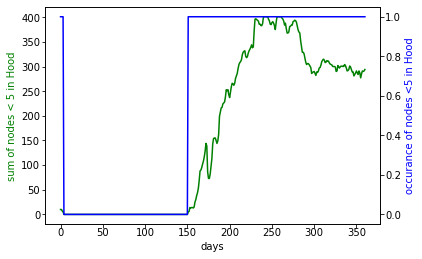

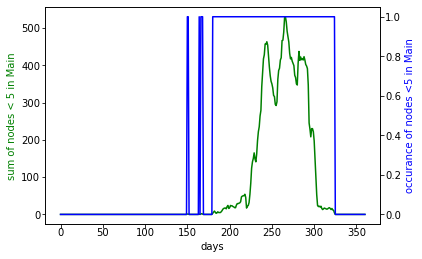

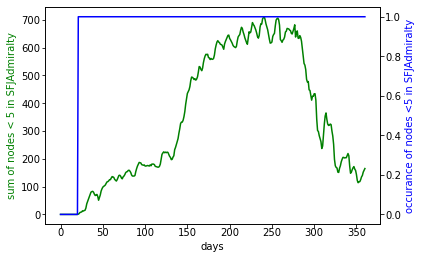

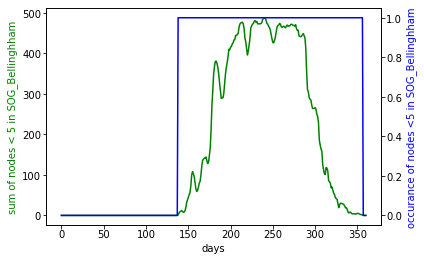

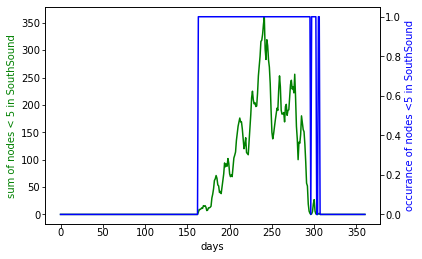

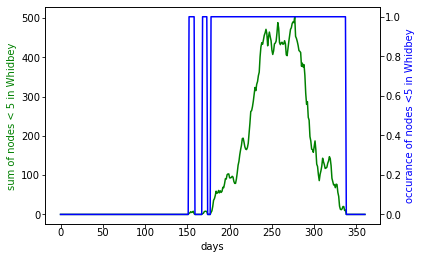

In [5]:
regions = gdf[['node_id','Regions']].groupby('Regions').count().index.to_list()
regions.remove('Other') # These will be removed in future iterations
for region in regions:
    # create boolean of indices where True selects nodes of 
    # specified Region 
    idx = ((gdf['Regions']==region) &
        (gdf['included_i']==1))
    # Assign the maximum (True) of DO < threshold occurrence across depths
    # Note: The max of True/False will be True and initial sets False to zero.
    # The "where" keywork specifies to only use values where idx=True,
    # which in this case I set to specify the region.
    DOBelowThresh_days = DOBelowThresh.max(axis=1,initial=0)
    # Assign the maximum (True) of DO < threshold occurrence across region
    DOBelowThresh_days_byregion = DOBelowThresh_days.max(axis=1,where=idx,initial=0)
    # Adds the maximum (True) of DO < threshold occurrence across region
    DOBelowThresh_nodedays_byregion = DOBelowThresh_days.sum(axis=1,where=idx,initial=0)

    # plot results
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(DOBelowThresh_nodedays_byregion, 'g-')
    ax2.plot(DOBelowThresh_days_byregion, 'b-')

    ax1.set_xlabel('days')
    ax1.set_ylabel(f'sum of nodes < 5 in {region}', color='g')
    ax2.set_ylabel(f'occurance of nodes <5 in {region}', color='b')

    plt.show()

# Below threshold   
Two options:
1. Use DO standard
2. Use given number (e.g. 2 mg/l or 5 mg/l)

In [6]:
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/'DOXG'
dir_list = os.listdir(processed_netcdf_dir)
dir_list

['wqm_reference',
 '1c_all_sog_riv_off',
 '2b_sog_river_2times',
 'wqm_baseline',
 '2a_sog_river_0.5times',
 '1d_small_sog_wwtp_off',
 '1e_med_sog_wwtp_off',
 '1b_all_sog_wwtp_off']

In [7]:
def calc_below_threshold(DO_thresh, shp, scope):
    """ 
    DO_thresh [1D or int]: DO_std or integer value
    shp [path]: shapefile path
    dir_list [list]: List of directory names for model output
    scope [string]: "benthic" or "wc" (for water column)
    """
    # Initialize dictionaries
    MinDO={}
    DOXGBelowThresh={} # Boolean where DOXG<threshold
    DOXGBelowThreshDays={} # Number of days where DOXGBelowThresh = True
    DaysDOXGBelowThresh={} # Sum of days across regions
    VolumeDays={} # Percent of volume within region where DO<threshold
    PercentVolumeDays={}
    
    # Define dimension sizes and load shapefile
    gdf = gpd.read_file(shp)
    gdf=gdf.rename(columns={'region_inf':'Regions'})
    regions = gdf[['node_id','Regions']].groupby('Regions').count().index.to_list()
    regions.remove('Other') # These will be removed in future iterations
    if DO_thresh=='DO_standard':
        DO_thresh=gdf['DO_std']
    
    # Get path for model output
    model_var='DOXG' 
    processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/model_var
    
    # Get list of run sub-directories in processed netcdf directory
    dir_list = os.listdir(processed_netcdf_dir)
    
    # Load all runs   
    if scope=='benthic':
        for run_dir in dir_list:
            try: 
                run_file=processed_netcdf_dir/run_dir/'bottom'/f'daily_min_{model_var}_bottom.nc'
                with xarray.open_dataset(run_file) as ds:
                    print([*ds])
                    MinDO_full=ds[f'{model_var}_daily_min_bottom']
                    # Sub-sample nodes (from 16012 nodes to 7494)
                    MinDO[run_dir]=MinDO_full[:,gdf['node_id']-1]
                    print(MinDO[run_dir].shape)
            except FileNotFoundError:
                print(f'File Not Found: {run_file}')
            if run_dir == dir_list[0]:
                # Get number of days and nodes
                [ndays,nnodes]=MinDO[run_dir].shape
    else: # water column (with 10 levels)
        for run_dir in dir_list:
            try: 
                run_file=processed_netcdf_dir/run_dir/f'daily_min_{model_var}.nc'
                with xarray.open_dataset(run_file) as ds:
                    print([*ds])
                    MinDO_full=ds[f'{model_var}_daily_min']
                    # Sub-sample nodes (from 16012 nodes to 7494)
                    MinDO[run_dir]=MinDO_full[:,:,gdf['node_id']-1]
                    print(MinDO[run_dir].shape)
            except FileNotFoundError:
                print(f'File Not Found: {run_file}')
            if run_dir == dir_list[0]:
                # Get number of days and nodes
                [ndays,nlevels,nnodes]=MinDO[run_dir].shape
                
    # Create array of Dissolved Oxygen threshold values
    if type(DO_thresh)==int:
        if scope=='benthic':
            DO_thresh2D = np.ones((nnodes,ndays))*DO_thresh
        else:
            DO_thresh3D = np.ones((nnodes,nlevels,ndays))*DO_thresh
    else:
        if scope=='benthic':
            # create array of DO_threshold values 
            DO_thresh2D = np.ones((nnodes,ndays))*np.array(DO_thresh).reshape(nnodes,1)
            # (7494,361) x (7494,1) => element-wise multiplication
        else:
            print(f'DO_thresh3D with DO_thresh={DO_thresh}')
            DO_thresh3D = np.ones((nnodes,nlevels,ndays))*np.array(DO_thresh).reshape(nnodes,1,1)

    # Calculate volume for volume days
    if scope=='benthic':
        volume = np.asarray(gdf.volume*ssm['siglev_diff'][-1]/100) # just the bottom level
    else: # water column
        volume = np.asarray(gdf.volume)
        depth_fraction = np.array(ssm['siglev_diff'])/100
        volume2D = np.dot(volume.reshape(nnodes,1),depth_fraction.reshape(1,nlevels))   
        
    # Determine DOXGBelowThresh days
    for run_type in dir_list:
        print(run_type)
        # Boolean where DOXG<threshold
        if scope=='benthic':
            DOXGBelowThresh[run_type] = MinDO[run_type]<=DO_thresh2D.transpose() #361x4144 (nodes x time)
            # Number of days where DOXGBelowThresh = True
###            DOXGBelowThreshDays[run_type]=DOXGBelowThresh[run_type].sum(axis=0) #4144 (nodes)
            # Volume days
            VolumeDays_all=volume*DOXGBelowThreshDays[run_type]
        else:
            DOXGBelowThresh[run_type] = MinDO[run_type]<=DO_thresh3D.transpose() #361x10x4144 (nodes x time)
            # First get a count of days below threshold for each depth level
            DOXGBelowThreshDays_wc=DOXGBelowThresh[run_type].sum(axis=0) #10x4144 (nodes)
            # Take max over depth to get result similar to benthic case where
            # 1-day of impairement is counted if there is one or more levels less than threshold
###            #DOXGBelowThreshDays[run_type]=DOXGBelowThresh[run_type].sum(axis=0).max(axis=0)
            # Volume days: Use days impaired for each level  and element-wise 
            # multiplication of 10x4144 * 10x4144 matrices to get volume days by level 
            VolumeDays_wc=volume*DOXGBelowThreshDays_wc
            # Add across levels to get total VolumeDays per node
            VolumeDays_all = VolumeDays_wc.sum(axis=0)
     
        # Total number of days and percent volume days for each region
        DaysDOXGBelowThresh[run_type]={}
        VolumeDays[run_type]={}
        PercentVolumeDays[run_type]={}
        for region in regions:
###            DaysDOXGBelowThresh[run_type][region]=np.array(DOXGBelowThreshDays[run_type])[
###                (gdf['Regions']==region) &
###                (gdf['included_i']==1)
###            ].sum()
            # create boolean of indices where True selects nodes of 
            # specified Region 
            idx = ((gdf['Regions']==region) &
                (gdf['included_i']==1))            
            # Note: The max of True/False will be True and initial sets False to zero.
            # The "where" keywork specifies to only use values where idx=True,
            # which in this case I set to specify the region.
            if scope=='benthic':
                # Assign the maximum (True) of DO < threshold occurrence across region
                DaysDOXGBelowThresh[run_type][region] = DOBelowThresh.max(
                    axis=1,where=idx,initial=0)
            else:
                # Assign the maximum (True) of DO < threshold occurrence across depths
                DOBelowThresh_daysnodes = DOBelowThresh.max(axis=1,initial=0)
                # Assign the maximum (True) of DO < threshold occurrence across region
                DaysDOXGBelowThresh[run_type][region] = DOBelowThresh_daysnodes.max(
                    axis=1,where=idx,initial=0)
            VolumeDays[run_type][region]=np.array(VolumeDays_all)[
                (gdf['Regions']==region) &
                (gdf['included_i']==1)
            ].sum()
            # get regional volume
            if scope=='benthic': # take fraction for bottom-level volume
                RegionVolume = ssm['siglev_diff'][-1]/100*volume[
                    (gdf['Regions']==region) &
                    (gdf['included_i']==1)
                ].sum()
            else: # water column
                RegionVolume = volume[
                    (gdf['Regions']==region) &
                    (gdf['included_i']==1)
                ].sum()
            PercentVolumeDays[run_type][region]=100*(
                VolumeDays[run_type][region]/(RegionVolume*ndays)
            )
     
        # Add sum across all region to the dataframe
        DaysDOXGBelowThresh[run_type]['TOTAL'] = np.array(
            [DaysDOXGBelowThresh[run_type][region] for region in [*DaysDOXGBelowThresh[run_type]]]
        ).sum()
        VolumeDays[run_type]['TOTAL'] = np.array(
            [VolumeDays[run_type][region] for region in [*VolumeDays[run_type]]]
        ).sum()
        PercentVolumeDays[run_type]['TOTAL'] = np.array(
            [PercentVolumeDays[run_type][region] for region in [*PercentVolumeDays[run_type]]]
        ).sum()
    # Convert to dataframe and organize information
    DaysDOXGBelowThresh_df = pandas.DataFrame(DaysDOXGBelowThresh)
    DaysDOXGBelowThresh_df = DaysDOXGBelowThresh_df.rename(columns=ssm['run_information']['run_tag'])
    DaysDOXGBelowThresh_df = DaysDOXGBelowThresh_df.reindex(columns=['Present Day','Reference','1b','1c','1d','1e','2a','2b'])
    # Percent of volume over the year in each region where DOXG change < threshold
    VolumeDays_df = pandas.DataFrame(VolumeDays)
    VolumeDays_df = VolumeDays_df.rename(columns=ssm['run_information']['run_tag'])
    VolumeDays_df = VolumeDays_df.reindex(columns=['Present Day','Reference','1b','1c','1d','1e','2a','2b'])
    # Percent of cumulative volume over the year in eash region where DOXG change < threshold
    PercentVolumeDays_df = pandas.DataFrame(PercentVolumeDays)
    PercentVolumeDays_df = PercentVolumeDays_df.rename(columns=ssm['run_information']['run_tag'])
    PercentVolumeDays_df = PercentVolumeDays_df.reindex(columns=['Present Day','Reference','1b','1c','1d','1e','2a','2b'])
    return DaysDOXGBelowThresh_df,VolumeDays_df,PercentVolumeDays_df

In [8]:
%%time
H={} #DOXG below threshold
VD={} #volume days
PVD={} # percent volume days
H['DO_std'],VD['DO_std'], PVD['DO_std']=calc_below_threshold(
    'DO_standard', shp, scope)
PVD['DO_std']

['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
wqm_reference
1c_all_sog_riv_off
2b_sog_river_2times
wqm_baseline
2a_sog_river_0.5times
1d_small_sog_wwtp_off
1e_med_sog_wwtp_off
1b_all_sog_wwtp_off
CPU times: user 22.7 s, sys: 12min 8s, total: 12min 30s
Wall time: 12min 38s


,Present Day,Reference,1b,1c,1d,1e,2a,2b
Hood,462.068315,458.192754,462.057220,462.038869,462.065614,462.060520,462.056920,462.089085
Main,439.286866,430.428173,439.264454,439.205089,439.281938,439.267711,439.242669,439.348856
SFJAdmiralty,730.566877,730.160349,730.558332,730.568212,730.565565,730.558538,730.568304,730.556543
SOG_Bellinghham,578.980438,578.257091,578.953275,578.999940,578.976525,578.955574,578.995686,578.962479
SouthSound,254.849501,242.191342,254.825536,254.742800,254.845664,254.832794,254.794006,254.953263
Whidbey,268.512106,254.127153,268.493849,268.334569,268.509394,268.501091,268.440990,268.671375
TOTAL,2734.264103,2693.356862,2734.152667,2733.889479,2734.244701,2734.176228,2734.098575,2734.581601


In [9]:
%%time
DO_thresh=2
H['2'], VD['2'], PVD['2']=calc_below_threshold(DO_thresh, shp, scope)
PVD['2']

['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
wqm_reference
1c_all_sog_riv_off
2b_sog_river_2times
wqm_baseline
2a_sog_river_0.5times
1d_small_sog_wwtp_off
1e_med_sog_wwtp_off
1b_all_sog_wwtp_off
CPU times: user 22.9 s, sys: 12min 7s, total: 12min 29s
Wall time: 12min 34s


,Present Day,Reference,1b,1c,1d,1e,2a,2b
Hood,10.111491,8.361224,10.101732,10.049673,10.109265,10.104856,10.082336,10.168124
Main,0.000135,0.000019,0.000135,0.000135,0.000135,0.000135,0.000135,0.000140
SFJAdmiralty,0.018834,0.018137,0.018834,0.018722,0.018834,0.018834,0.018826,0.018911
SOG_Bellinghham,0.012143,0.010254,0.011509,0.010254,0.012143,0.011555,0.011232,0.015088
SouthSound,0.013458,0.002578,0.013458,0.013297,0.013458,0.013458,0.013458,0.013851
Whidbey,0.081937,0.039263,0.081497,0.081060,0.081937,0.081497,0.081497,0.082084
TOTAL,10.237997,8.431475,10.227164,10.173140,10.235772,10.230334,10.207483,10.298199


In [10]:
%%time
DO_thresh=5
H['5'], VD['5'], PVD['5']=calc_below_threshold(DO_thresh, shp, scope)
PVD['5']

['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
wqm_reference
1c_all_sog_riv_off
2b_sog_river_2times
wqm_baseline
2a_sog_river_0.5times
1d_small_sog_wwtp_off
1e_med_sog_wwtp_off
1b_all_sog_wwtp_off
CPU times: user 23.3 s, sys: 12min 7s, total: 12min 30s
Wall time: 12min 34s


,Present Day,Reference,1b,1c,1d,1e,2a,2b
Hood,234.559995,228.265732,234.529142,234.379398,234.552128,234.539976,234.470607,234.756986
Main,28.245747,19.965284,28.217717,28.072442,28.238500,28.226342,28.157495,28.426219
SFJAdmiralty,419.398338,418.893924,419.387856,419.374120,419.397341,419.390626,419.385274,419.443915
SOG_Bellinghham,212.922461,211.727027,212.887170,212.783898,212.919662,212.894987,212.845855,213.079347
SouthSound,15.096801,10.368231,15.088598,15.021201,15.094860,15.090096,15.058805,15.166802
Whidbey,91.992979,76.734087,91.958655,91.770736,91.984033,91.965194,91.890099,92.214295
TOTAL,1002.216320,965.954285,1002.069137,1001.401794,1002.186525,1002.107221,1001.808135,1003.087563


## Write to two files, one each for: 
- Impaired
- Hypoxic

In [11]:
this_file = '=HYPERLINK("https://github.com/RachaelDMueller/KingCounty-Rachael/blob/main/notebooks/dev_days_impaired.ipynb","dev_days_impaired.ipynb")'
run_description = '=HYPERLINK("https://uwnetid.sharepoint.com/:x:/r/sites/og_uwt_psi/Shared%20Documents/Nutrient%20Science/9.%20Modeling/Municipal%20%20model%20runs%20and%20scripting%20task%20list_0803.xlsx?d=wc2379d95258844a0b0b611347c90e748&csf=1&web=1&e=ENBajh", "Municipal  model runs and scripting task list")'
ndays = 'Number of days where DO < threshold anywhere in Region (or in benthic layer of region if benthic case)'
vd = 'Total volume of cells in region that experienced DO < threshold over the course of the year'
pvd='Percent of regional volume that experienced DO < threshold over the course of the year'

created_by = 'Rachael D. Mueller'
created_on = date.today().strftime("%B %d, %Y")
header = {
    ' ':[created_by, created_on, this_file, run_description, ndays, vd, pvd]
}
header_df = pandas.DataFrame(header, index=['Created by:',
                               'Created on:',
                               'Created with:',
                               'Reference:',
                               'Number_of_Days',
                               'Volume_Days [km^3]',
                               'Percent_Volume_Days'])

excel_output_path = pathlib.Path(ssm['paths']['processed_output'])/case
if os.path.exists(excel_output_path)==False:
        print(f'creating: {excel_output_path}')
        os.umask(0) #clears permissions
        os.makedirs(excel_output_path, mode=0o777,exist_ok=True)
with pandas.ExcelWriter(excel_output_path/f'{case}_{scope}_DO-lt-DOstd.xlsx', mode='w') as writer:  
    H['DO_std'].to_excel(writer, sheet_name='Number_of_Days')
    VD['DO_std'].to_excel(writer, sheet_name='Volume_Days')
    PVD['DO_std'].to_excel(writer, sheet_name='Percent_Volume_Days')
    header_df.to_excel(writer, sheet_name='README')
with pandas.ExcelWriter(excel_output_path/f'{case}_{scope}_DO-lt-2.xlsx', mode='w') as writer:  
    H['2'].to_excel(writer, sheet_name='Number_of_Days')
    VD['2'].to_excel(writer, sheet_name='Volume_Days')
    PVD['2'].to_excel(writer, sheet_name='Percent_Volume_Days')
    header_df.to_excel(writer, sheet_name='README')
with pandas.ExcelWriter(excel_output_path/f'{case}_{scope}_DO-lt-5.xlsx', mode='w') as writer:  
    H['5'].to_excel(writer, sheet_name='Number_of_Days')
    VD['5'].to_excel(writer, sheet_name='Volume_Days')
    PVD['5'].to_excel(writer, sheet_name='Percent_Volume_Days')
    header_df.to_excel(writer, sheet_name='README')


### Impaired
As defined by the Optimization Scenario Report Appendix F, version(?) B (add link/definition)

In [12]:
def calc_impaired(shp, scope, impairment=-0.2):
    """ 
    """
    # Initialize dictionaries
    MinDO_full={} # Min, daily DO over all nodes
    MinDO={} # Min, daily DO over all nodes in shapefile
    DO_diff_lt_0p2={} # Boolean where DO<threshold
    DO_diff_lt_0p2_days={} # Number of days where DOBelowThresh = True
    DaysImpaired={} # Sum of days across regions
    VolumeDaysImpaired={} # Percent of volume within region where DO<threshold
    PercentVolumeDaysImpaired={}
     
    # Define dimension sizes and load shapefile
    gdf = gpd.read_file(shp)
    gdf = gdf.rename(columns={'region_inf':'Regions'})
    regions = gdf[['node_id','Regions']].groupby('Regions').count().index.to_list()
    regions.remove('Other')
    
    [Nnodes,nattrs]=gdf.shape
    Nlevels=10
    # Calculate volume for volume days
    if scope=='benthic':
        volume = np.asarray(gdf.volume*ssm['siglev_diff'][-1]/100) # just the bottom level
    else: # water column
        volume = np.asarray(gdf.volume)
        depth_fraction = np.array(ssm['siglev_diff'])/100
        volume2D = np.dot(volume.reshape(Nnodes,1),depth_fraction.reshape(1,Nlevels))
    
    # Get path for model output
    model_var='DOXG' 
    processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/model_var
    
    # Get list of run sub-directories in processed netcdf directory
    dir_list = os.listdir(processed_netcdf_dir)
    
    # Load all runs   
    if scope=='benthic':
        for run_dir in dir_list:
            try: 
                run_file=processed_netcdf_dir/run_dir/'bottom'/f'daily_min_{model_var}_bottom.nc'
                with xarray.open_dataset(run_file) as ds:
                    print([*ds])
                    MinDO_full[run_dir]=ds[f'{model_var}_daily_min_bottom']
                    # Sub-sample nodes (from 16012 nodes to 7494)
                    MinDO[run_dir]=MinDO_full[run_dir][:,gdf['node_id']-1]
                    print(MinDO[run_dir].shape)
            except FileNotFoundError:
                print(f'File Not Found: {run_file}')
            if run_dir == dir_list[0]:
                # Get number of days and nodes
                [ndays,nnodes]=MinDO[run_dir].shape
    else: # water column (with 10 levels)
        for run_dir in dir_list:
            try: 
                run_file=processed_netcdf_dir/run_dir/f'daily_min_{model_var}.nc'
                with xarray.open_dataset(run_file) as ds:
                    print([*ds])
                    MinDO_full[run_dir]=ds[f'{model_var}_daily_min']
                    # Sub-sample nodes (from 16012 nodes to 7494)
                    MinDO[run_dir]=MinDO_full[run_dir][:,:,gdf['node_id']-1]
                    print(MinDO[run_dir].shape)
            except FileNotFoundError:
                print(f'File Not Found: {run_file}')
            if run_dir == dir_list[0]:
                # Get number of days and nodes
                [ndays,nlevels,nnodes]=MinDO[run_dir].shape

    # Define reference run
    reference = ssm['run_information']['reference']
    dir_list.remove('wqm_reference')
    
    # Loop through all non-reference runs and calculate impairment
    for run_type in dir_list:
        print(f'Calculating difference for {run_type}')
        # Create array of Dissolved Oxygen threshold values 
        DO_diff = MinDO[run_type] - MinDO[reference]
        # Boolean where DO_diff<0.2
        DO_diff_lt_0p2[run_type] = DO_diff<=impairment #361x4144 (nodes x time) or 361x10x4144
        # Number of days where DO < threshold = True
        if scope=='benthic':
            DO_diff_lt_0p2_days[run_type]=DO_diff_lt_0p2[run_type].sum(axis=0) #4144 (nodes) or 10x4144
            VolumeDays_all=volume*DO_diff_lt_0p2_days[run_type]
        else: # water column: sum over days and take max value over depth
            # First get a count of days impaired for each depth level
            DO_diff_lt_0p2_days_wc=DO_diff_lt_0p2[run_type].sum(axis=0)
            # Take max over depth to get result similar to benthic case where
            # 1-day of impairement is counted if there is one or more levels impaired
            DO_diff_lt_0p2_days[run_type]=DO_diff_lt_0p2[run_type].sum(axis=0).max(axis=0)
            # Volume days: Use days impaired for each level  and element-wise 
            # multiplication of 10x4144 * 10x4144 matrices to get volume days by level
            VolumeDays_wc=volume*DO_diff_lt_0p2_days_wc
            # Add across levels to get total VolumeDays per node
            VolumeDays_all = VolumeDays_wc.sum(axis=0)
        
        # Total number of days and percent volume days for each region
        DaysImpaired[run_type]={}
        VolumeDaysImpaired[run_type]={}
        PercentVolumeDaysImpaired[run_type]={}
        for region in regions:
###            DaysImpaired[run_type][region]=np.array(DO_diff_lt_0p2_days[run_type])[
###                (gdf['Regions']==region) &
###                (gdf['included_i']==1)
###            ].sum()
            # create boolean of indices where True selects nodes of 
            # specified Region 
            idx = ((gdf['Regions']==region) &
                (gdf['included_i']==1))            
            # Note: The max of True/False will be True and initial sets False to zero.
            # The "where" keywork specifies to only use values where idx=True,
            # which in this case I set to specify the region.
            if scope=='benthic':
                # Assign the maximum (True) of DO < threshold occurrence across region
                DaysImpaired[run_type][region] = DO_diff_lt_0p2[run_type].max(
                    axis=1,where=idx,initial=0)
            else:
                # Assign the maximum (True) of DO < threshold occurrence across depths
                DOBelowThresh_daysnodes = DO_diff_lt_0p2_days[run_type].max(axis=1,initial=0)
                # Assign the maximum (True) of DO < threshold occurrence across region
                DaysImpaired[run_type][region] = DOBelowThresh_daysnodes.max(
                    axis=1,where=idx,initial=0)
            
            VolumeDaysImpaired[run_type][region]=np.array(VolumeDays_all)[
                (gdf['Regions']==region) &
                (gdf['included_i']==1)
            ].sum()
            # get regional volume
            if scope=='benthic': # take fraction for bottom-level volume
                RegionVolume = ssm['siglev_diff'][-1]/100*volume[
                    (gdf['Regions']==region) &
                    (gdf['included_i']==1)
                ].sum()
            else: # water column
                RegionVolume = volume[
                    (gdf['Regions']==region) &
                    (gdf['included_i']==1)
                ].sum()
            PercentVolumeDaysImpaired[run_type][region]=100*(
                VolumeDaysImpaired[run_type][region]/(RegionVolume*ndays)
            )
        # Add sum across all region to the dataframe
        DaysImpaired[run_type]['TOTAL'] = np.array(
            [DaysImpaired[run_type][region] for region in [*DaysImpaired[run_type]]]
        ).sum()
        VolumeDaysImpaired[run_type]['TOTAL'] = np.array(
            [VolumeDaysImpaired[run_type][region] for region in [*VolumeDaysImpaired[run_type]]]
        ).sum()
        PercentVolumeDaysImpaired[run_type]['TOTAL'] = np.array(
            [PercentVolumeDaysImpaired[run_type][region] for region in [*PercentVolumeDaysImpaired[run_type]]]
        ).sum()
    # Convert to dataframe and organize information
    DaysImpaired_df = pandas.DataFrame(DaysImpaired)
    DaysImpaired_df = DaysImpaired_df.rename(columns=ssm['run_information']['run_tag'])
    DaysImpaired_df = DaysImpaired_df.reindex(columns=['Present Day','Reference','1b','1c','1d','1e','2a','2b'])
    DaysImpaired_df = DaysImpaired_df.drop(['Reference'],axis=1) # drop empty column
    # Percent of volume over the year in each region where DO change < threshold
    VolumeDaysImpaired_df = pandas.DataFrame(VolumeDaysImpaired)
    VolumeDaysImpaired_df = VolumeDaysImpaired_df.rename(
        columns=ssm['run_information']['run_tag'])
    VolumeDaysImpaired_df = VolumeDaysImpaired_df.reindex(
        columns=['Present Day','Reference','1b','1c','1d','1e','2a','2b'])
    VolumeDaysImpaired_df = VolumeDaysImpaired_df.drop(['Reference'],axis=1) # drop empty column
    # Percent of cumulative volume over the year in eash region where DO change < threshold
    PercentVolumeDaysImpaired_df = pandas.DataFrame(PercentVolumeDaysImpaired)
    PercentVolumeDaysImpaired_df = PercentVolumeDaysImpaired_df.rename(
        columns=ssm['run_information']['run_tag'])
    PercentVolumeDaysImpaired_df = PercentVolumeDaysImpaired_df.reindex(
        columns=['Present Day','Reference','1b','1c','1d','1e','2a','2b'])
    VolumeDaysImpaired_df = VolumeDaysImpaired_df.drop(['Reference'],axis=1) # drop empty column
    
    return DaysImpaired_df,VolumeDaysImpaired_df,PercentVolumeDaysImpaired_df

In [13]:
%%time
scope = 'wc'
DaysImpaired_df,VolumeDays_df,PercentVolumeDays_df = calc_impaired(shp, scope)

['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)
Calculating difference for 1c_all_sog_riv_off


AttributeError: 'dict' object has no attribute 'max'

In [14]:
this_file = '=HYPERLINK("https://github.com/RachaelDMueller/KingCounty-Rachael/blob/main/notebooks/dev_days_impaired.ipynb","dev_days_impaired.ipynb")'
run_description = '=HYPERLINK("https://uwnetid.sharepoint.com/:x:/r/sites/og_uwt_psi/Shared%20Documents/Nutrient%20Science/9.%20Modeling/Municipal%20%20model%20runs%20and%20scripting%20task%20list_0803.xlsx?d=wc2379d95258844a0b0b611347c90e748&csf=1&web=1&e=ENBajh", "Municipal  model runs and scripting task list")'
ndays = 'Number of days where DO(scenario) - DO(reference) < -0.2 anywhere in Region (or in benthic layer of region if benthic case)'
vd = 'Total volume of cells in region (or benthic layer in region) that experienced DO(scenario) - DO(reference) < -0.2 over the course of the years"
pvd='Percent of regional (or benthic) volume that experienced DO(scenario) - DO(reference) < -0.2 over the course of the year'

created_by = 'Rachael D. Mueller'
created_on = date.today().strftime("%B %d, %Y")
header = {
    ' ':[created_by, created_on, this_file, run_description, ndays, vd, pvd]
}
header_df = pandas.DataFrame(header, index=['Created by:',
                               'Created on:',
                               'Created with:',
                               'Reference:',
                               'Impaired_Days',
                               'Volume_Days [km^3]',
                               'Percent_Volume_Days'])

excel_output_path = pathlib.Path(ssm['paths']['processed_output'])/case   
if os.path.exists(excel_output_path)==False:
        print(f'creating: {excel_output_path}')
        os.umask(0) #clears permissions
        os.makedirs(excel_output_path, mode=0o777,exist_ok=True)
with pandas.ExcelWriter(excel_output_path/f'{case}_{scope}_impaired.xlsx', mode='w') as writer:  
    DaysImpaired_df.to_excel(writer, sheet_name='Impaired_Days')
    VolumeDays_df.to_excel(writer, sheet_name='Volume_Days')
    PercentVolumeDays_df.to_excel(writer, sheet_name='Percent_Volume_Days')
    header_df.to_excel(writer, sheet_name='README')

SyntaxError: unterminated string literal (detected at line 4) (1072400924.py, line 4)

## Test water columns calculation

In [ ]:
benthic_file=processed_netcdf_dir/run_dir/'bottom'/f'daily_{np_operator}_{model_var}_bottom.nc'
with xarray.open_dataset(benthic_file) as ds:
    print([*ds])
    MinDO_full=ds[f'{model_var}_daily_{np_operator}_bottom']
    # Sub-sample basin footprint (from 16012 nodes to 7494)
    MinDO=MinDO_full[:,gdf['node_id']-1]

In [ ]:
wc_file = processed_netcdf_dir/run_dir/f'daily_{np_operator}_{model_var}.nc'
with xarray.open_dataset(wc_file) as ds:
    print([*ds])
    MinDO_wc=ds[f'{model_var}_daily_{np_operator}']
    MinDO=MinDO_wc[:,:,gdf['node_id']-1]
volume2D = np.dot(volume.reshape(4144,1),depth_fraction.reshape(1,10))

In [ ]:
MinDO_full

In [ ]:
MinDO

In [ ]:
volume = np.asarray(gdf.volume)
volume.reshape(4144,1).shape

In [ ]:
depth_fraction = np.array(ssm['siglev_diff'])/100
depth_fraction.reshape(1,10).shape

In [ ]:
volume2D[0,:]

In [ ]:
volume[0]*np.array(ssm['siglev_diff'])/100

In [ ]:
np.sum(volume[0]*np.array(ssm['siglev_diff'])/100) - volume[0]

In [ ]:
volume*np.array(ssm['siglev_diff'])/100